In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score, train_test_split
from mlxtend.feature_selection import SequentialFeatureSelector

In [ ]:
#8.A
np.random.seed(2025)
X = np.random.rand(100)
betas = [3.141592, 62, 5, 10]
noise = np.random.normal(0,1, size = X.shape)
y = betas[0] + (betas[1] * X) + (betas[2] * X **2) + (betas[3] * X ** 3) + noise


df = pd.DataFrame(X)
df = df.rename(columns = {0:'X1'})
df['y'] = y
df.head()



,x1,y
0,0.135488,10.267746
1,0.887852,68.282294
2,0.932606,73.051194
3,0.445568,31.784556
4,0.388236,29.757004


In [ ]:
#8.C
for i in range(2, 11):
    df[f'X{i}'] = df['X1'] ** i
df.head()



,x1,y,X2,X3,X4,X5,X6,X7,X8,X9,X10
0,0.135488,10.267746,0.018357,0.002487,0.000337,0.000046,0.000006,8.381264e-07,1.135562e-07,1.538552e-08,2.084556e-09
1,0.887852,68.282294,0.788281,0.699876,0.621386,0.551699,0.489827,4.348936e-01,3.861210e-01,3.428182e-01,3.043717e-01
2,0.932606,73.051194,0.869753,0.811137,0.756471,0.705489,0.657943,6.136013e-01,5.722480e-01,5.336817e-01,4.977146e-01
3,0.445568,31.784556,0.198531,0.088459,0.039415,0.017562,0.007825,3.486575e-03,1.553507e-03,6.921933e-04,3.084193e-04
4,0.388236,29.757004,0.150727,0.058518,0.022719,0.008820,0.003424,1.329435e-03,5.161339e-04,2.003815e-04,7.779523e-05


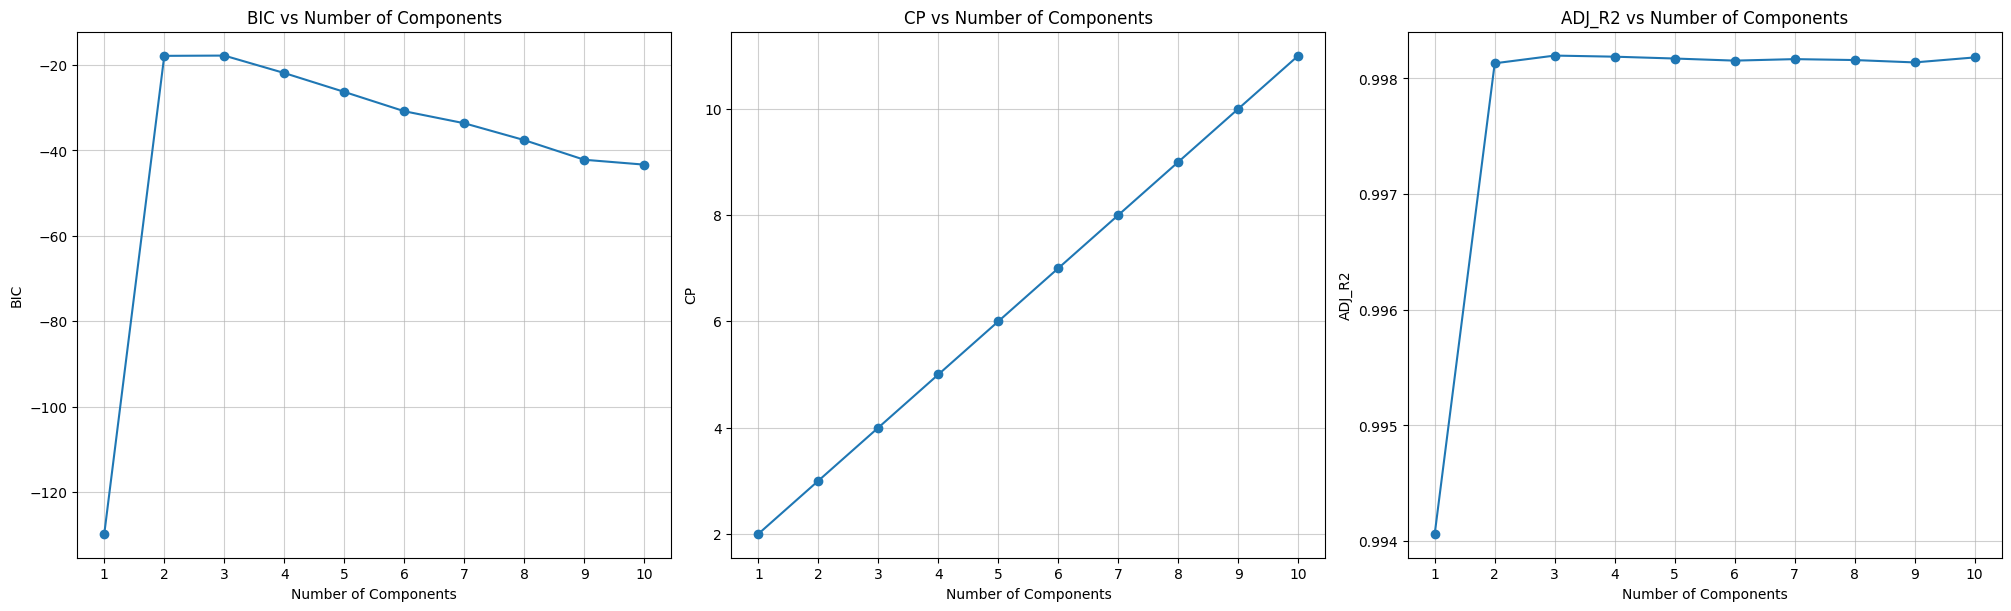

In [ ]:
#8.C
from typing import List
def bic_score(model, X, y):
    """Calcula el BIC dado un modelo ya ajustado."""
    y_pred = model.predict(X)
    n = len(y)
    resid = y - y_pred
    rss = np.sum(resid ** 2)
    k = len(model.coef_) + 1
    bic = n * np.log(rss / n) + k * np.log(n)
    return -bic

def r2_adj_score(model, X, y):
    """Calcula el R² ajustado dado un modelo ya ajustado."""
    n = len(y)
    p = len(model.coef_)
    r2 = model.score(X, y)
    r2_adj = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    return r2_adj
def cp_score(model, X, y):
    y_pred = model.predict(X)
    n = len(y)
    resid = y - y_pred
    rss = np.sum(resid ** 2)
    sigma2 = rss / (n - len(model.coef_) - 1)
    cp = rss / sigma2 - n + 2 * (len(model.coef_) + 1)
    return cp


def optimal_components_multiple(metrics, scores_dict):
    """Grafica múltiples métricas en una fila."""
    fig, axes = plt.subplots(1, len(metrics), figsize=(20, 6), constrained_layout=True)
    for ax, metric in zip(axes, metrics):
        scores = scores_dict[metric]
        ax.plot(range(1, len(scores) + 1), scores, marker='o')
        ax.set_title(f'{metric.upper()} vs Number of Components')
        ax.set_xlabel('Number of Components')
        ax.set_ylabel(metric.upper())
        ax.set_xticks(range(1, len(scores) + 1))
        ax.grid(alpha=0.6)
    plt.show()

def model_evaluate_and_plot(df, metrics):
    """Evalúa y genera gráficos para todas las métricas."""
    y = df['y']
    X = df.drop('y', axis=1)
    scores_dict = {metric: [] for metric in metrics}
    columns = []
    lr = LinearRegression()

    for col in X.columns:
        columns.append(col)
        X_subset = X[columns]

        for metric in metrics:
            model = lr.fit(X_subset, y)
            if metric == 'bic':
                scores_dict[metric].append(bic_score(model, X_subset, y))
            elif metric == 'cp':
                scores_dict[metric].append(cp_score(model, X_subset, y))
            elif metric == 'adj_r2':
                scores_dict[metric].append(r2_adj_score(model, X_subset, y))


    optimal_components_multiple(metrics, scores_dict)



metrics = ['bic', 'cp', 'adj_r2']
model_evaluate_and_plot(df, metrics)


The BIC and Cp tell us the best number of components is 1. Lets use a CV with 10 splits using forward selection and check if it is true.

In [ ]:
#8.D
X = df.drop(['y'], axis = 1)
y = df['y']
lr = LinearRegression()
sfs = SequentialFeatureSelector(lr, k_features='best', cv = 10, forward=True, n_jobs=-1, scoring = 'neg_mean_squared_error')
model = sfs.fit(X, y)
pd.DataFrame.from_dict(sfs.get_metric_dict()).T



,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(0,)","[-2.2470250310737705, -4.67727621632018, -3.34...",-3.498349,"(x1,)",1.026777,1.382468,0.460823
2,"(0, 2)","[-1.122412231162422, -0.982665410490208, -0.85...",-1.047002,"(x1, X3)",0.142716,0.192155,0.064052
3,"(0, 1, 2)","[-1.1179222826517505, -0.9806814800119259, -0....",-1.075573,"(x1, X2, X3)",0.15438,0.207859,0.069286
4,"(0, 1, 2, 3)","[-1.1166720157571888, -0.9608928572597744, -0....",-1.096839,"(x1, X2, X3, X4)",0.181618,0.244533,0.081511
5,"(0, 1, 2, 3, 4)","[-1.1114224394013468, -0.9626467443598745, -0....",-1.132983,"(x1, X2, X3, X4, X5)",0.211452,0.284703,0.094901
6,"(0, 1, 2, 3, 4, 5)","[-1.152991062336066, -1.006435265290086, -0.85...",-1.171205,"(x1, X2, X3, X4, X5, X6)",0.256309,0.345098,0.115033
7,"(0, 1, 2, 3, 4, 5, 6)","[-1.0563026929257364, -0.9706949412407659, -1....",-1.16363,"(x1, X2, X3, X4, X5, X6, X7)",0.233024,0.313747,0.104582
8,"(0, 1, 2, 3, 4, 5, 6, 7)","[-1.1147050315640314, -0.9715290549331419, -1....",-1.178241,"(x1, X2, X3, X4, X5, X6, X7, X8)",0.234874,0.316238,0.105413
9,"(0, 1, 2, 3, 4, 5, 6, 7, 8)","[-1.1170603947330118, -0.9861494751986937, -1....",-1.196657,"(x1, X2, X3, X4, X5, X6, X7, X8, X9)",0.246345,0.331683,0.110561
10,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)","[-1.2307248158592308, -0.9685363596235744, -1....",-1.18182,"(x1, X2, X3, X4, X5, X6, X7, X8, X9, X10)",0.223239,0.300573,0.100191


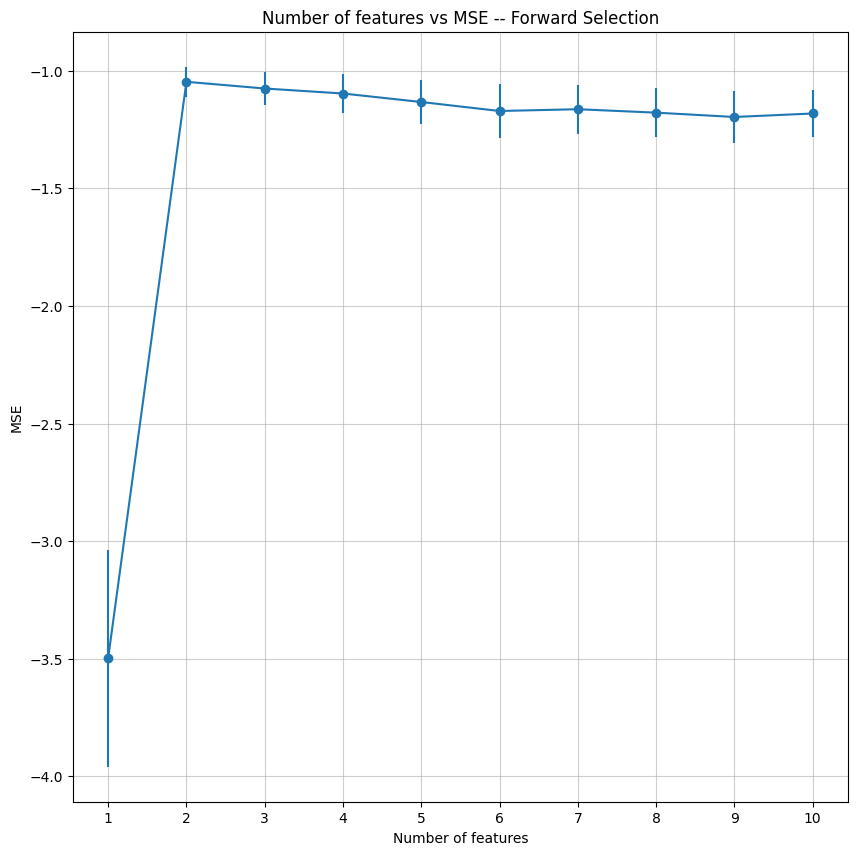

In [ ]:
def plot_sfs(df1, method):
    fig, ax = plt.subplots(figsize = (10,10))
    ax.errorbar(range(1, len(df1['feature_names']) + 1),
                df1['avg_score'],
                yerr = df1['std_err'], marker = 'o')
    ax.set_title(f'Number of features vs MSE -- {method}')
    ax.set_xlabel('Number of features')
    ax.set_ylabel('MSE')
    ax.grid(alpha = 0.6)
    ax.set_xticks(ticks = range(1, len(df1['feature_names'])+1))
    fig.show()

df1 = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
plot_sfs(df1, 'Forward Selection')


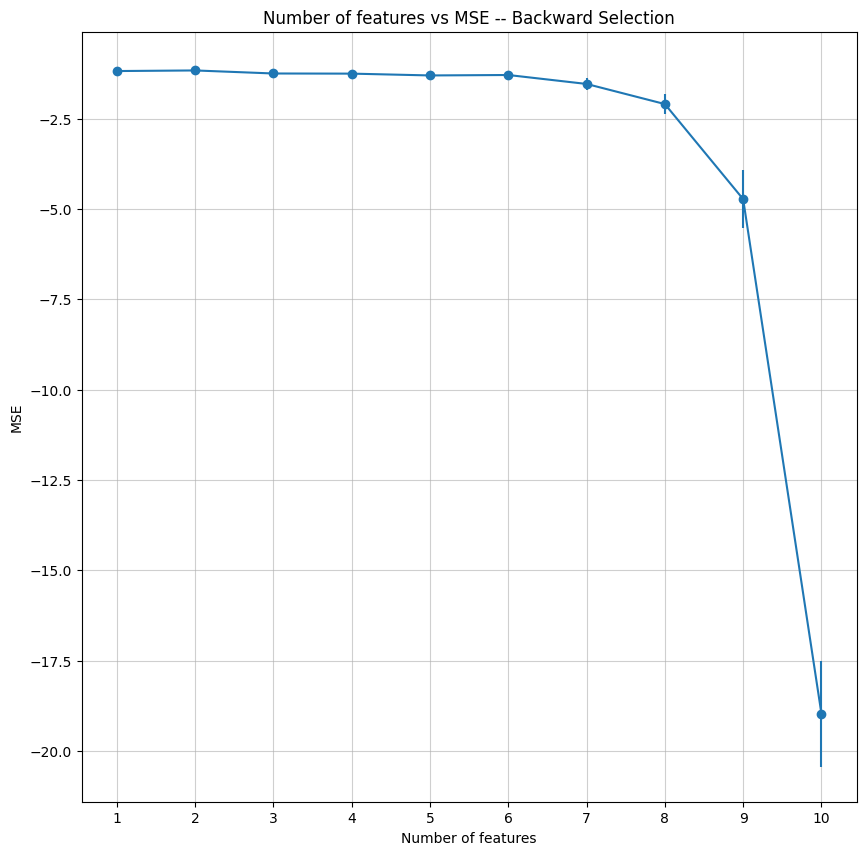

In [ ]:
lr = LinearRegression()
sfs2 = SequentialFeatureSelector(lr, cv = 10, scoring = 'neg_mean_squared_error', k_features = 'best', forward = False, n_jobs = -1)
sfs2.fit(X, y)

df2 = pd.DataFrame.from_dict(sfs2.get_metric_dict()).T
plot_sfs(df2, 'Backward Selection')




Both methods tell us that selecting 2 or 3 variables is the right choice.

In [ ]:
#8.E
lambdas = np.logspace(-4, 1, 50)
lasso = Lasso(fit_intercept = True)
param_grid = {'alpha': lambdas}
grid = GridSearchCV(lasso, param_grid = param_grid, cv = 10, scoring = 'neg_mean_squared_error', n_jobs =-1)
model = grid.fit(X, y)

The best MSE was: -1.0742
The best value for $\lambda$ was: 0.004291934260128779


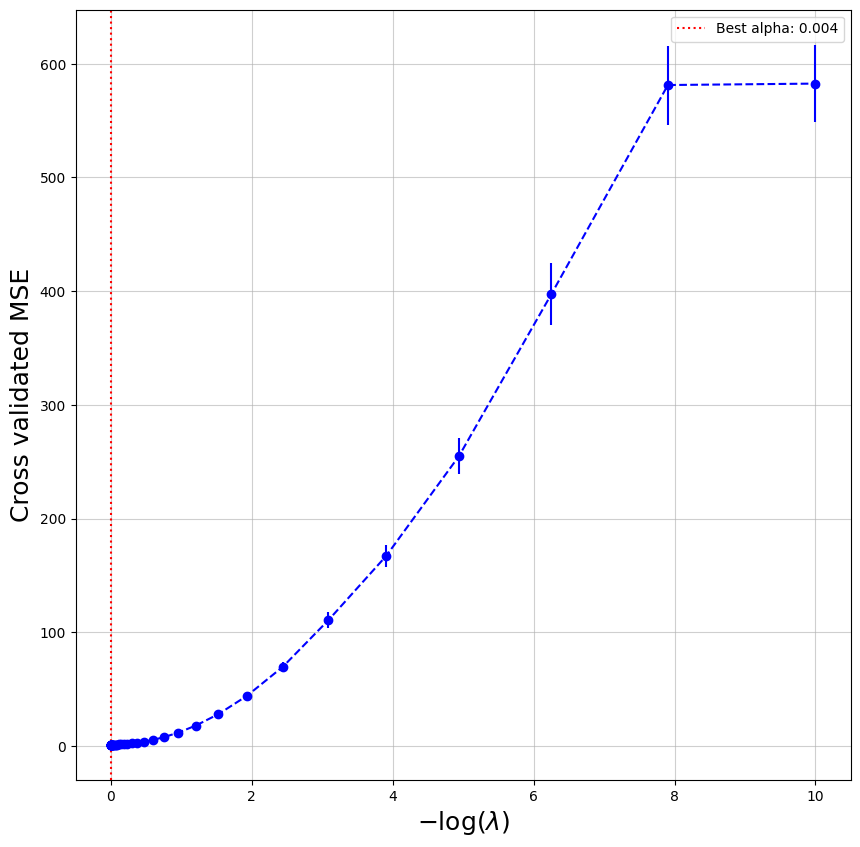

In [ ]:
def plot_values_lambda(model, lambdas):
    Kf = 10
    mean_scores = -model.cv_results_['mean_test_score']
    std_scores = model.cv_results_['std_test_score']

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.errorbar(lambdas, mean_scores, yerr=std_scores / np.sqrt(Kf), marker='o', linestyle='--', color='blue')
    ax.axvline(x= -model.best_params_['alpha'], color='red', linestyle=':', label=f'Best alpha: {model.best_params_["alpha"]:.3f}')

    ax.set_xlabel('$-\log(\lambda)$', fontsize=18)
    ax.set_ylabel('Cross validated MSE', fontsize=18)
    ax.legend()
    ax.grid(alpha = 0.6)
    fig.show()


print(f'The best MSE was: {model.best_score_:.4f}')
print(f'The best value for $\lambda$ was: {model.best_params_["alpha"]}')
plot_values_lambda(model, lambdas)





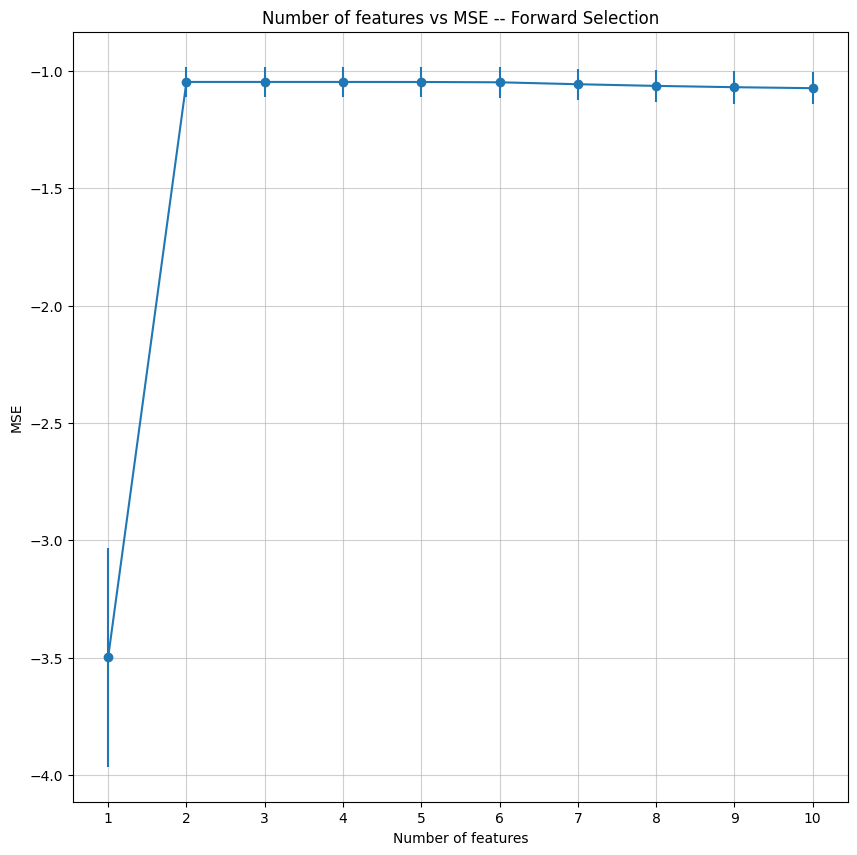

In [ ]:
lasso_best = Lasso(alpha=0.004, fit_intercept = True)
sfs3 = SequentialFeatureSelector(lasso_best, cv=10, scoring='neg_mean_squared_error', k_features='best', forward=True, n_jobs=-1)
sfs3.fit(X, y)
df3 = pd.DataFrame.from_dict(sfs3.get_metric_dict()).T
plot_sfs(df3, 'Forward Selection')

Still the best model is somewhere between 2 or 3.


In [ ]:
#8.F
new_betas = [30, 44]
X = np.random.rand(100)
noise = np.random.normal(0, 1, size = X.shape)
y = (new_betas[0] + new_betas[1] * X ** 7) + noise

df = pd.DataFrame(X)
df = df.rename(columns = {0: 'X1'})



for i in range(2,11):
    df[f'X{i}'] = df['X1'] ** i

df['y'] = y
df


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,y
0,0.312205,0.097472,0.030431,0.009501,0.002966,0.000926,2.891201e-04,9.026472e-05,2.818109e-05,8.798275e-06,30.101266
1,0.298649,0.089191,0.026637,0.007955,0.002376,0.000710,2.118968e-04,6.328269e-05,1.889929e-05,5.644249e-06,31.089554
2,0.119035,0.014169,0.001687,0.000201,0.000024,0.000003,3.386257e-07,4.030827e-08,4.798091e-09,5.711402e-10,31.900845
3,0.474489,0.225140,0.106827,0.050688,0.024051,0.011412,5.414847e-03,2.569288e-03,1.219100e-03,5.784502e-04,29.890048
4,0.997621,0.995248,0.992881,0.990519,0.988163,0.985813,9.834677e-01,9.811283e-01,9.787946e-01,9.764663e-01,71.845561
...,...,...,...,...,...,...,...,...,...,...,...
95,0.440646,0.194169,0.085560,0.037702,0.016613,0.007320,3.225736e-03,1.421408e-03,6.263377e-04,2.759932e-04,29.704504
96,0.693988,0.481619,0.334238,0.231957,0.160976,0.111715,7.752893e-02,5.380415e-02,3.733943e-02,2.591312e-02,33.242416
97,0.402197,0.161763,0.065060,0.026167,0.010524,0.004233,1.702448e-03,6.847198e-04,2.753924e-04,1.107621e-04,28.772341
98,0.892176,0.795977,0.710151,0.633580,0.565264,0.504315,4.499375e-01,4.014233e-01,3.581400e-01,3.195238e-01,50.188213


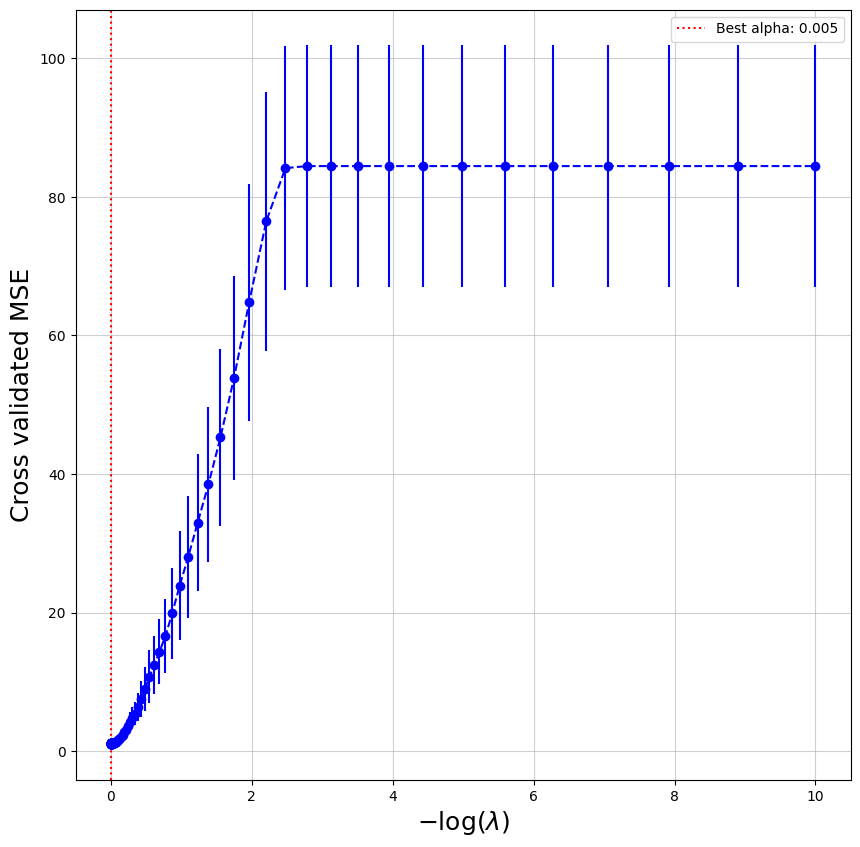

In [ ]:
X = df.drop(['y'], axis = 1)
y = df['y']
lasso2 = Lasso(fit_intercept = True)
lambdas = np.logspace(-4,1,100)
param_grid = {'alpha': lambdas}
grid = GridSearchCV(lasso2, param_grid = param_grid, cv = 10, scoring = 'neg_mean_squared_error', n_jobs = -1)
model = grid.fit(X, y)

plot_values_lambda(model, lambdas)

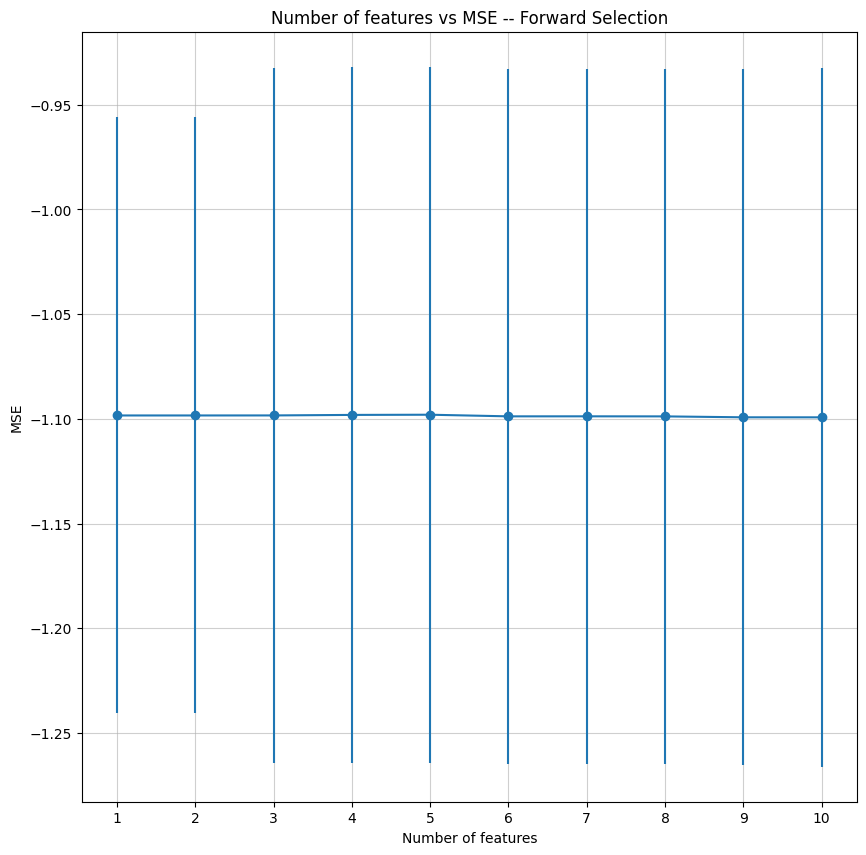

In [ ]:
lasso = Lasso(alpha = 0.005, fit_intercept = True)
sfs4 = SequentialFeatureSelector(lasso, cv = 10, scoring = 'neg_mean_squared_error', n_jobs =-1, forward = True, k_features='parsimonious')
sfs4.fit(X, y)

df4 = pd.DataFrame.from_dict(sfs4.get_metric_dict()).T
plot_sfs(df4, 'Forward Selection')

In [ ]:
df4

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(6,)","[-0.7063031356074461, -0.657524419163642, -0.8...",-1.098378,"(X7,)",0.317049,0.426879,0.142293
2,"(6, 7)","[-0.7063031356074461, -0.657524419163642, -0.8...",-1.098378,"(X7, X8)",0.317049,0.426879,0.142293
3,"(4, 6, 7)","[-0.708239361697262, -0.6672479213903089, -0.7...",-1.098362,"(X5, X7, X8)",0.369849,0.49797,0.16599
4,"(4, 6, 7, 8)","[-0.7103875647222438, -0.6890314050917844, -0....",-1.098116,"(X5, X7, X8, X9)",0.370394,0.498704,0.166235
5,"(4, 5, 6, 7, 8)","[-0.7091814451112567, -0.6872300767270465, -0....",-1.098023,"(X5, X6, X7, X8, X9)",0.370224,0.498475,0.166158
6,"(3, 4, 5, 6, 7, 8)","[-0.708967341766637, -0.6944191462147231, -0.7...",-1.098801,"(X4, X5, X6, X7, X8, X9)",0.369735,0.497817,0.165939
7,"(1, 3, 4, 5, 6, 7, 8)","[-0.7096475279168615, -0.6982450930180136, -0....",-1.098788,"(X2, X4, X5, X6, X7, X8, X9)",0.369522,0.497529,0.165843
8,"(1, 2, 3, 4, 5, 6, 7, 8)","[-0.7096229744168295, -0.698536468103564, -0.7...",-1.098817,"(X2, X3, X4, X5, X6, X7, X8, X9)",0.369498,0.497498,0.165833
9,"(0, 1, 2, 3, 4, 5, 6, 7, 8)","[-0.7100427169458963, -0.6983907904095779, -0....",-1.099259,"(X1, X2, X3, X4, X5, X6, X7, X8, X9)",0.370268,0.498535,0.166178
10,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)","[-0.7118359202758081, -0.6989944407146138, -0....",-1.09927,"(X1, X2, X3, X4, X5, X6, X7, X8, X9, X10)",0.371703,0.500466,0.166822


In [ ]:
selected_features = list(sfs4.k_feature_names_)
lasso_selected = Lasso(alpha=0.005, fit_intercept=True)
lasso_selected.fit(X[selected_features], y)
coefficients = lasso_selected.coef_
intercept = lasso_selected.intercept_
print(f"The value of the intercept (Beta_0) is: {intercept:.4f}")
for feature, coef in zip(selected_features, coefficients):
    print(f"The value of Beta for {feature} is: {coef:.4f}")


print(f'The Real values of the coefficients are: Beta_0 = {new_betas[0]:.4f}, Beta_1 = {new_betas[1]:.4f}')

The value of the intercept (Beta_0) is: 30.1664
The value of Beta for X7 is: 42.6092
The Real values of the coefficients are: Beta_0 = 30.0000, Beta_1 = 44.0000
